# **Detection of ACL injuries using Vision Transformer**  - 2022


*   Dataset used is [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/)











In [ ]:
import os
import timm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils import data
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
from sklearn import metrics
import imgaug.augmenters as iaa
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
# Constants
MRNET_PATH = '/content/drive/MyDrive/MRNet-v1.0/'
TRAIN_PATH = '/content/drive/MyDrive/MRNet-v1.0/train/'
VAL_PATH = '/content/drive/MyDrive/MRNet-v1.0/valid/'
BATCH_SIZE = 16
RANDOM_STATE = 1234
EPOCHS = 50
PATIENT = 10
LOSS_IMPROVE = 1e-04
MAX_PIXEL_VALUE = 255

In [ ]:
# Seeds
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

In [ ]:
class MRDataset(data.Dataset):
    def __init__(self, transform=False, train=True, train_index_limit=1130, target_size=(224, 224)):
        super().__init__()
        self.transform = transform
        self.train = train
        self.target_size = target_size
        self.records = pd.read_csv(MRNET_PATH + '/knee_metadata.csv')
        self.train_index_limit = train_index_limit
        self.planes = ['axial', 'sagittal', 'coronal']
        self.image_path = {}

        if self.train:
            for plane in self.planes:
                self.image_path[plane] = TRAIN_PATH + '/{0}/'.format(plane)
            self.records = self.records.iloc[0:self.train_index_limit, :]
        else:
            for plane in self.planes:
                self.image_path[plane] = VAL_PATH + '/{0}/'.format(plane)
            self.records = self.records.iloc[self.train_index_limit:, :]

        self.records['Image'] = self.records['Image'].map(lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = {}
        for plane in self.planes:
            self.paths[plane] = [self.image_path[plane] + filename + '.npy' for filename in self.records['Image'].tolist()]

        self.labels = self.records[['Abnormal', 'ACL', 'Meniscus']].values
        weights_ = []
        for disease in range(3):
            pos = sum(self.labels[:, disease])
            neg = len(self.labels[:, disease]) - pos
            weights_.append(neg / pos)
        self.weights = torch.FloatTensor(weights_)

    def __len__(self):
        return len(self.records)

    def resize_image(self, img):
        """
        Resizes the image to the target size.
        Ensures the tensor has the correct shape for 2D resizing.
        """
        if img.ndim == 3:
            img = img[0]
        img = torch.FloatTensor(img)
        img = img.unsqueeze(0).unsqueeze(0)
        img = F.interpolate(img, size=self.target_size, mode='bilinear', align_corners=False)
        return img.squeeze(0)


    def __getitem__(self, index):
        transform = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(
                translate_percent={"x": (-0.11, 0.11), "y": (-0.11, 0.11)},
                scale={"x": (1, 1.2), "y": (1, 1.2)},
                rotate=(-10, 10)
            )
        ])

        img_raw = {}
        for plane in self.planes:
            img = np.load(self.paths[plane][index])
            img = img / MAX_PIXEL_VALUE

            if self.transform:
                img = transform(images=img)

            img = self.resize_image(img)
            img_raw[plane] = img.repeat(3, 1, 1)

        label = torch.FloatTensor(self.labels[index])
        return [img_raw[plane] for plane in self.planes], label

In [ ]:
class VisionTransformerMRNet(nn.Module):
    def __init__(self, model_name='vit_tiny_patch16_224'):
        super(VisionTransformerMRNet, self).__init__()
        # Initialize ViT models for each view
        self.vit_axial = timm.create_model(model_name, pretrained=True, in_chans=3)
        self.vit_sagittal = timm.create_model(model_name, pretrained=True, in_chans=3)
        self.vit_coronal = timm.create_model(model_name, pretrained=True, in_chans=3)

        # Update the classifier head
        num_features = self.vit_axial.head.in_features
        self.vit_axial.head = nn.Identity()
        self.vit_sagittal.head = nn.Identity()
        self.vit_coronal.head = nn.Identity()

        # Classifier combining outputs from all three views
        self.classifier = nn.Sequential(
            nn.Linear(num_features * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 3)
        )

        # Attention weights for multi-view fusion
        self.attention_weights = nn.Parameter(torch.ones(3) / 3)

    def forward(self, x):
        # Get features from each ViT
        x_axial = self.vit_axial(x[0])
        x_sagittal = self.vit_sagittal(x[1])
        x_coronal = self.vit_coronal(x[2])

        # Weighted fusion of features
        weights = torch.softmax(self.attention_weights, dim=0)
        x_axial = x_axial * weights[0]
        x_sagittal = x_sagittal * weights[1]
        x_coronal = x_coronal * weights[2]

        # Combine features and classify
        combined = torch.cat([x_axial, x_sagittal, x_coronal], dim=1)
        return self.classifier(combined)


In [ ]:
def get_sensitivity_specificity(y_true, y_pred):
    abnormal_true = list(map(lambda x: x[0], y_true))
    abnormal_pred = list(map(lambda x: x[0], y_pred))
    ACL_true = list(map(lambda x: x[1], y_true))
    ACL_pred = list(map(lambda x: x[1], y_pred))
    meniscus_true = list(map(lambda x: x[2], y_true))
    meniscus_pred = list(map(lambda x: x[2], y_pred))

    tn_ab, fp_ab, fn_ab, tp_ab = metrics.confusion_matrix(abnormal_true, abnormal_pred).ravel()
    tn_acl, fp_acl, fn_acl, tp_acl = metrics.confusion_matrix(ACL_true, ACL_pred).ravel()
    tn_men, fp_men, fn_men, tp_men = metrics.confusion_matrix(meniscus_true, meniscus_pred).ravel()

    sensitivity = [round(tp_ab / (tp_ab + fn_ab), 4), round(tp_acl / (tp_acl + fn_acl), 4), round(tp_men / (tp_men + fn_men), 4)]
    specificity = [round(tn_ab / (tn_ab + fp_ab), 4), round(tn_acl / (tn_acl + fp_acl), 4), round(tn_men / (tn_men + fp_men), 4)]
    return sensitivity, specificity

In [ ]:
def train(train_data, model, criterion):
    model.train()
    counter = 0
    correct = 0
    train_running_loss = 0.0
    total = 0.0
    prediction_list = []
    label_list = []

    for input_data, label in tqdm(train_data):
        input_data = [data.to(device) for data in input_data]
        label = label.to(device)

        counter += 1
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(input_data)
            outputs_sig = torch.sigmoid(outputs)
            predicted = torch.round(outputs_sig)

            prediction_list.append(list(predicted.cpu().detach().numpy())[0])
            label_list.append(list(label.cpu().detach().numpy())[0])

            total += label.size(1)
            correct += (np.array(predicted.cpu().detach().numpy())[0] ==
                       np.array(label.cpu().detach().numpy())[0]).sum().item()

            loss = criterion(outputs, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_running_loss += loss.item()

    train_accuracy = correct / total
    train_loss = train_running_loss / counter
    train_auc = metrics.roc_auc_score(label_list, prediction_list, average='macro', multi_class='ovr')

    return train_loss, train_accuracy, train_auc, prediction_list

In [ ]:
def val(val_data, model, criterion):
    model.eval()
    counter = 0
    correct = 0
    val_running_loss = 0.0
    total = 0.0
    prediction_list = []
    label_list = []

    with torch.no_grad():
        for input_data, label in tqdm(val_data):
            input_data = [data.to(device) for data in input_data]
            label = label.to(device)

            counter += 1
            outputs = model(input_data)
            outputs_sig = torch.sigmoid(outputs)
            predicted = torch.round(outputs_sig)

            prediction_list.append(list(predicted.cpu().detach().numpy())[0])
            label_list.append(list(label.cpu().detach().numpy())[0])

            total += label.size(1)
            correct += (np.array(predicted.cpu().detach().numpy())[0] ==
                       np.array(label.cpu().detach().numpy())[0]).sum().item()

            loss = criterion(outputs, label)
            val_running_loss += loss.item()

    val_accuracy = correct / total
    val_loss = val_running_loss / counter
    val_auc = metrics.roc_auc_score(label_list, prediction_list, average='macro', multi_class='ovr')
    sensitivity, specificity = get_sensitivity_specificity(label_list, prediction_list)

    return val_loss, val_accuracy, val_auc, prediction_list, sensitivity, specificity

In [ ]:
# Initialize datasets and loaders
train_dataset = MRDataset(transform=True, target_size=(224, 224))
val_dataset = MRDataset(train=False, target_size=(224, 224))

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
# Model and optimization setup
model = VisionTransformerMRNet(model_name='vit_tiny_patch16_224').to(device)
train_criterion = nn.BCEWithLogitsLoss(pos_weight=train_dataset.weights.to(device))
val_criterion = nn.BCEWithLogitsLoss(pos_weight=val_dataset.weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(),  lr=1e-05, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

<ipython-input-14-d24827fc6819>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# Early Stopping Parameters
best_val_loss = float('inf')
early_stopping_patience = PATIENT  # Number of epochs to wait before stopping
patient_counter = 0

# Track Best Metrics
best_metrics = {
    'epoch': 0,
    'val_accuracy': 0.0,
    'val_auc': 0.0,
    'val_sensitivity': [0.0, 0.0, 0.0],
    'val_specificity': [0.0, 0.0, 0.0]
}

# Lists to store metrics for plotting
train_accuracies, val_accuracies = [], []
train_aucs, val_aucs = [], []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")

    train_epoch_loss, train_epoch_accuracy, train_epoch_auc, train_predictions = train(
        train_loader, model, train_criterion)

    val_epoch_loss, val_epoch_accuracy, val_epoch_auc, val_predictions, val_sensitivity, val_specificity = val(
        val_loader, model, val_criterion)

    scheduler.step()

    # Check for improvement in validation loss
    if val_epoch_loss < best_val_loss - LOSS_IMPROVE:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_epoch_loss:.4f}. Saving model...")
        best_val_loss = val_epoch_loss
        patient_counter = 0
        torch.save(model.state_dict(), f'{MRNET_PATH}/models/vit_mrnet_model_best.pth')

        # Update best metrics
        best_metrics.update({
            'epoch': epoch + 1,
            'val_accuracy': val_epoch_accuracy,
            'val_auc': val_epoch_auc,
            'val_sensitivity': val_sensitivity,
            'val_specificity': val_specificity
        })
    else:
        print("Validation loss did not improve.")
        patient_counter += 1

    # Early stopping
    if patient_counter >= early_stopping_patience:
        print("Early stopping triggered. Training halted.")
        break

    # Store epoch metrics for plotting
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    train_aucs.append(train_epoch_auc)
    val_aucs.append(val_epoch_auc)

    print(f"Train Acc: {train_epoch_accuracy:.4f} | Val Acc: {val_epoch_accuracy:.4f}")
    print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")
    print(f"Train AUC: {train_epoch_auc:.4f} | Val AUC: {val_epoch_auc:.4f}")
    print("Val-Sensitivity. Abnormal: {:.4f}, ACL: {:.4f}, Meniscus: {:.4f}".format(*val_sensitivity))
    print("Val-Specificity. Abnormal: {:.4f}, ACL: {:.4f}, Meniscus: {:.4f}".format(*val_specificity))
    print("-" * 80)

Epoch 1 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [01:34<00:00, 11.83s/it]


Validation loss improved from inf to 0.5966. Saving model...
Train Acc: 0.5634 | Val Acc: 0.7083
Train Loss: 0.7506 | Val Loss: 0.5966
Train AUC: 0.5426 | Val AUC: 0.7056
Val-Sensitivity. Abnormal: 0.8333, ACL: 0.0000, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 1.0000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 2 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Validation loss improved from 0.5966 to 0.5625. Saving model...
Train Acc: 0.6714 | Val Acc: 0.7083
Train Loss: 0.7135 | Val Loss: 0.5625
Train AUC: 0.6956 | Val AUC: 0.7500
Val-Sensitivity. Abnormal: 0.8333, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 3 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Validation loss improved from 0.5625 to 0.5501. Saving model...
Train Acc: 0.7887 | Val Acc: 0.6667
Train Loss: 0.6652 | Val Loss: 0.5501
Train AUC: 0.7926 | Val AUC: 0.6889
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 0.6667
Val-Specificity. Abnormal: 1.0000, ACL: 0.4000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 4 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Validation loss improved from 0.5501 to 0.5422. Saving model...
Train Acc: 0.7653 | Val Acc: 0.7083
Train Loss: 0.6339 | Val Loss: 0.5422
Train AUC: 0.7904 | Val AUC: 0.7444
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.4000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 5 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


Validation loss improved from 0.5422 to 0.5351. Saving model...
Train Acc: 0.7653 | Val Acc: 0.7083
Train Loss: 0.6079 | Val Loss: 0.5351
Train AUC: 0.7888 | Val AUC: 0.7056
Val-Sensitivity. Abnormal: 0.8333, ACL: 0.3333, Meniscus: 0.6667
Val-Specificity. Abnormal: 1.0000, ACL: 1.0000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 6 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Validation loss improved from 0.5351 to 0.5232. Saving model...
Train Acc: 0.7277 | Val Acc: 0.7083
Train Loss: 0.5921 | Val Loss: 0.5232
Train AUC: 0.7261 | Val AUC: 0.7222
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.3333, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 7 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Validation loss improved from 0.5232 to 0.5218. Saving model...
Train Acc: 0.7840 | Val Acc: 0.6667
Train Loss: 0.5685 | Val Loss: 0.5218
Train AUC: 0.7715 | Val AUC: 0.6889
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.3333, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.4000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 8 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Validation loss did not improve.
Train Acc: 0.7606 | Val Acc: 0.7500
Train Loss: 0.5440 | Val Loss: 0.5267
Train AUC: 0.7618 | Val AUC: 0.7556
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.3333, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.8000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 9 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation loss did not improve.
Train Acc: 0.7700 | Val Acc: 0.7500
Train Loss: 0.5185 | Val Loss: 0.5304
Train AUC: 0.8087 | Val AUC: 0.7778
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 10 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Validation loss did not improve.
Train Acc: 0.7793 | Val Acc: 0.8333
Train Loss: 0.4841 | Val Loss: 0.5226
Train AUC: 0.7872 | Val AUC: 0.8667
Val-Sensitivity. Abnormal: 1.0000, ACL: 1.0000, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.8000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 11 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Validation loss improved from 0.5218 to 0.5214. Saving model...
Train Acc: 0.8263 | Val Acc: 0.7083
Train Loss: 0.4666 | Val Loss: 0.5214
Train AUC: 0.8333 | Val AUC: 0.7222
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 0.6667
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 12 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Validation loss improved from 0.5214 to 0.5177. Saving model...
Train Acc: 0.8122 | Val Acc: 0.7917
Train Loss: 0.4517 | Val Loss: 0.5177
Train AUC: 0.8063 | Val AUC: 0.8111
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.8000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 13 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Validation loss did not improve.
Train Acc: 0.8028 | Val Acc: 0.7500
Train Loss: 0.4241 | Val Loss: 0.5428
Train AUC: 0.8158 | Val AUC: 0.7778
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 14 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Validation loss did not improve.
Train Acc: 0.8451 | Val Acc: 0.7500
Train Loss: 0.4217 | Val Loss: 0.5412
Train AUC: 0.8640 | Val AUC: 0.7778
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 15 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Validation loss did not improve.
Train Acc: 0.8545 | Val Acc: 0.8333
Train Loss: 0.3881 | Val Loss: 0.5428
Train AUC: 0.8572 | Val AUC: 0.8444
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.8000, Meniscus: 0.6000
--------------------------------------------------------------------------------
Epoch 16 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Validation loss did not improve.
Train Acc: 0.8732 | Val Acc: 0.7500
Train Loss: 0.3553 | Val Loss: 0.5422
Train AUC: 0.8954 | Val AUC: 0.7778
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 17 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Validation loss did not improve.
Train Acc: 0.8498 | Val Acc: 0.7500
Train Loss: 0.3452 | Val Loss: 0.5564
Train AUC: 0.8812 | Val AUC: 0.7778
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 18 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Validation loss did not improve.
Train Acc: 0.8216 | Val Acc: 0.7500
Train Loss: 0.3322 | Val Loss: 0.5577
Train AUC: 0.8053 | Val AUC: 0.7778
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.6000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 19 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Validation loss did not improve.
Train Acc: 0.7887 | Val Acc: 0.7917
Train Loss: 0.3043 | Val Loss: 0.5863
Train AUC: 0.7962 | Val AUC: 0.7889
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.3333, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.8000, Meniscus: 0.6000
--------------------------------------------------------------------------------
Epoch 20 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Validation loss did not improve.
Train Acc: 0.9202 | Val Acc: 0.7500
Train Loss: 0.2892 | Val Loss: 0.5961
Train AUC: 0.9257 | Val AUC: 0.7556
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.3333, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.8000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 21 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Validation loss did not improve.
Train Acc: 0.8685 | Val Acc: 0.7917
Train Loss: 0.2690 | Val Loss: 0.5706
Train AUC: 0.8754 | Val AUC: 0.8111
Val-Sensitivity. Abnormal: 1.0000, ACL: 0.6667, Meniscus: 1.0000
Val-Specificity. Abnormal: 1.0000, ACL: 0.8000, Meniscus: 0.4000
--------------------------------------------------------------------------------
Epoch 22 of 50


  0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-11-a4e1e4cadd8d>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 8/8 [00:06<00:00,  1.20it/s]

Validation loss did not improve.
Early stopping triggered. Training halted.


In [ ]:
# Print Final Metrics
print("\nTraining Complete!")
print("\nFinal Metrics:")
final_table = [
    ["Metric", "Abnormal", "ACL", "Meniscus"],
    ["Sensitivity"] + best_metrics['val_sensitivity'],
    ["Specificity"] + best_metrics['val_specificity'],
]
print(tabulate(final_table, headers="firstrow", tablefmt="grid"))
print(f"Best Epoch: {best_metrics['epoch']}")
print(f"Best Validation Accuracy: {best_metrics['val_accuracy']:.4f}")
print(f"Best Validation AUC: {best_metrics['val_auc']:.4f}")


Training Complete!

Final Metrics:
+-------------+------------+--------+------------+
| Metric      |   Abnormal |    ACL |   Meniscus |
+=============+============+========+============+
| Sensitivity |          1 | 0.6667 |        1   |
+-------------+------------+--------+------------+
| Specificity |          1 | 0.8    |        0.4 |
+-------------+------------+--------+------------+
Best Epoch: 12
Best Validation Accuracy: 0.7917
Best Validation AUC: 0.8111


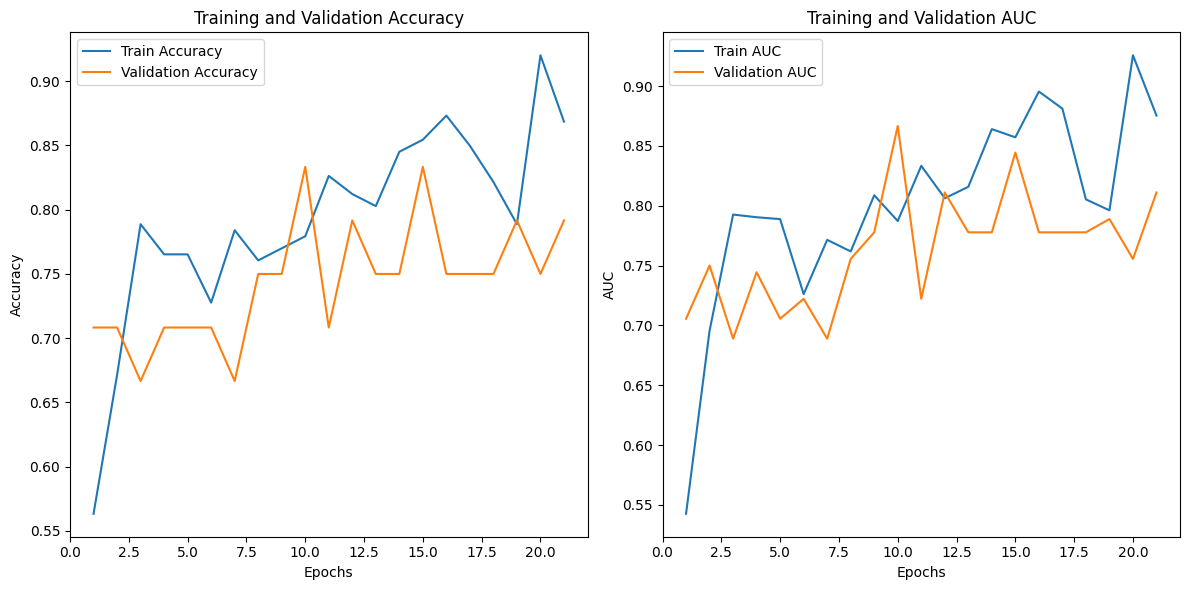

In [ ]:
# Plot Metrics
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# AUC Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_aucs) + 1), train_aucs, label='Train AUC')
plt.plot(range(1, len(val_aucs) + 1), val_aucs, label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.savefig(f'{MRNET_PATH}/training_validation_metrics.png')
plt.show()
